In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 학습, 검증, 테스트 데이터 로드
train_df = pd.read_csv('train.hate.csv')  # 학습 데이터 로드
dev_df = pd.read_csv('dev.hate.csv')      # 검증 데이터 로드
test_df = pd.read_csv('test.hate.no_label.csv')    # 테스트 데이터 로드

In [ ]:
# 각 라벨의 개수를 확인하여 데이터 분포를 파악
print("Train 데이터 분포:")
print(train_df['label'].value_counts())  # 학습 데이터 분포 확인
print("Dev 데이터 분포:")
print(dev_df['label'].value_counts())    # 검증 데이터 분포 확인

Train 데이터 분포:
label
no           3486
offensive    2499
hate         1911
Name: count, dtype: int64
Dev 데이터 분포:
label
offensive    189
no           160
hate         122
Name: count, dtype: int64


In [ ]:
# 라벨링 변환 (예: 'none' -> 0, 'offensive' -> 1, 'hate' -> 2)
label_mapping = {'no': 0, 'offensive': 1, 'hate': 2}
train_df['label'] = train_df['label'].map(label_mapping)
dev_df['label'] = dev_df['label'].map(label_mapping)

# 결측치 확인 및 제거
train_df = train_df.dropna(subset=['label', 'comments'])
dev_df = dev_df.dropna(subset=['label', 'comments'])

# 라벨 변환 후 Null 값 제거
train_df = train_df.dropna(subset=['label'])
dev_df = dev_df.dropna(subset=['label'])

# 빈 데이터셋이 아닌지 확인
if train_df.empty:
    raise ValueError("학습 데이터셋이 비어 있습니다. 데이터 파일의 내용을 확인하세요.")
if dev_df.empty:
    raise ValueError("검증 데이터셋이 비어 있습니다. 데이터 파일의 내용을 확인하세요.")

# 데이터 분포 확인 (결측치 처리 후)
print("Train 데이터 분포:")
print(train_df['label'].value_counts())
print("\nDev 데이터 분포:")
print(dev_df['label'].value_counts())

Train 데이터 분포:
label
0    3486
1    2499
2    1911
Name: count, dtype: int64

Dev 데이터 분포:
label
1    189
0    160
2    122
Name: count, dtype: int64


In [ ]:
from transformers import ElectraForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch

# KcELECTRA 모델과 토크나이저 로드
model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

def encode_data(data):
    # 텍스트 토큰화 및 변환
    encodings = tokenizer(
        data['comments'].tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # max_length를 지정하여 입력 길이 제한
    )
    return encodings

# 학습 및 검증 데이터 토큰화
train_encodings = encode_data(train_df)
val_encodings = encode_data(dev_df)

# 라벨을 텐서로 변환
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(dev_df['label'].values)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# 데이터셋 생성
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [ ]:
# 학습 설정 정의
training_args = TrainingArguments(
    output_dir='./results',              # 모델 출력 경로
    num_train_epochs=3,                  # 학습 에폭 수
    per_device_train_batch_size=16,      # 학습 배치 크기
    per_device_eval_batch_size=16,       # 평가 배치 크기
    warmup_steps=500,                    # 워밍업 단계
    eval_strategy="epoch",             # 평가 주기
    logging_dir='./logs',                # 로그 디렉토리
    logging_steps=10,                     # 로그 출력 주기
    report_to="none"  # WandB 비활성화
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# 모델 학습
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.780400,0.851888
2,0.630700,0.737700
3,0.335000,0.893889


TrainOutput(global_step=1482, training_loss=0.6383245605246419, metrics={'train_runtime': 101.7344, 'train_samples_per_second': 232.842, 'train_steps_per_second': 14.567, 'total_flos': 900809897063328.0, 'train_loss': 0.6383245605246419, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측 수행
predictions = trainer.predict(val_dataset)
y_preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)
y_true = dev_df['label']

# 평가지표 출력
print(classification_report(y_true, y_preds, target_names=['no', 'offensive', 'hate']))

# 혼동행렬 출력
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_preds))

# 테스트 데이터 예측
test_encodings = encode_data(test_df)
test_dataset = CustomDataset(test_encodings)
test_predictions = trainer.predict(test_dataset)
test_preds = torch.argmax(torch.tensor(test_predictions.predictions), axis=1)

# 예측 결과를 데이터프레임에 저장
output_df = test_df.copy()
output_df['label'] = test_preds.numpy()

# CSV 파일로 저장
output_df.to_csv('test.hate.predicted_KcELECTRA_v2.csv', index=False)
print("테스트 데이터의 예측 결과가 test.hate.predicted.csv 파일에 저장되었습니다.")

              precision    recall  f1-score   support

          no       0.67      0.92      0.77       160
   offensive       0.64      0.54      0.59       189
        hate       0.82      0.61      0.70       122

    accuracy                           0.69       471
   macro avg       0.71      0.69      0.69       471
weighted avg       0.70      0.69      0.68       471

Confusion Matrix:
[[147  12   1]
 [ 71 103  15]
 [  2  45  75]]


테스트 데이터의 예측 결과가 test.hate.predicted.csv 파일에 저장되었습니다.


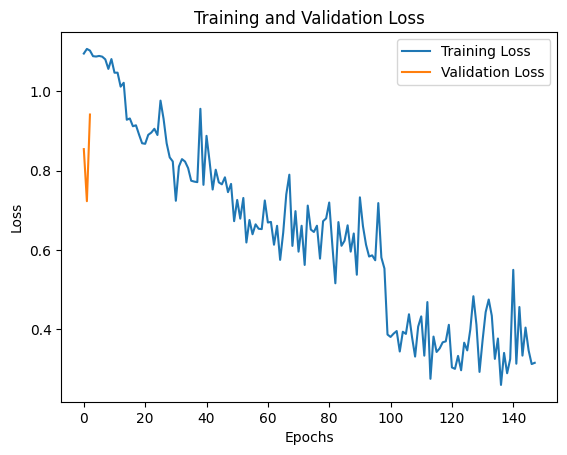

모델이 과적합되었습니다. 검증 손실이 학습 손실보다 높습니다.


In [ ]:
# 학습 및 검증 손실 기록 확인
training_logs = trainer.state.log_history

train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]

# 손실 시각화를 통한 과적합 여부 판단
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 과적합 및 과소적합 판단 출력
if train_loss[-1] < eval_loss[-1]:
    print("모델이 과적합되었습니다. 검증 손실이 학습 손실보다 높습니다.")
elif train_loss[-1] > eval_loss[-1] and (train_loss[-1] - eval_loss[-1]) > 0.1:
    print("모델이 과소적합일 가능성이 있습니다. 학습 손실이 검증 손실보다 상당히 높습니다.")
else:
    print("모델이 적절히 학습되었습니다.")

In [ ]:
# 모델 및 토크나이저 저장
model.save_pretrained('./saved_model_KcELECTRA_v1')
tokenizer.save_pretrained('./saved_model_KcELECTRA_v1')

('./saved_model_KcELECTRA_v1/tokenizer_config.json',
 './saved_model_KcELECTRA_v1/special_tokens_map.json',
 './saved_model_KcELECTRA_v1/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# 저장된 모델을 압축하여 다운로드 가능하도록 준비
shutil.make_archive('saved_model_KcELECTRA_v1', 'zip', './saved_model_KcELECTRA_v1')

# 파일 다운로드
files.download('saved_model_KcELECTRA_v1.zip')

KeyboardInterrupt: 

In [ ]:

# 테스트 데이터 예측
test_encodings = encode_data(test_df)
test_dataset = CustomDataset(test_encodings, torch.zeros(len(test_df)))
test_predictions = trainer.predict(test_dataset)
test_preds = torch.argmax(torch.tensor(test_predictions.predictions), axis=1)

# 예측 결과를 데이터프레임에 저장
output_df = test_df.copy()
output_df['predicted_label'] = test_preds.numpy()

# CSV 파일로 저장
output_df.to_csv('test.hate.predicted.csv', index=False)
print("테스트 데이터의 예측 결과가 test.hate.predicted.csv 파일에 저장되었습니다.")

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'